# Exercise 5. Classification

The aim of this exercise is to train 4 a machine learning models for predicting the forest main tree species from satellite data.

It also assesses the model accuracy with a test dataset but also predicts the main tree species for whole image (the cropped version).

The forest stands and Sentinel 2A satellite data produced by Exercise 2 are used.

In [25]:
import os, time
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
import numpy as np
import rasterio
from rasterio.merge import merge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [8]:
#Set working directory and input/output file names.
base_folder = "/home/jovyan/work/geocomputing/machineLearning/data/forest"

# Input
inputImage =  os.path.join(base_folder,'T34VFM_20180829T100019_clipped_scaled.tif')
labelsImage =  os.path.join(base_folder,'forest_species_reclassified_clip.tif')

# Output
outputImageBase= os.path.join(base_folder,'T34VFM_20180829T100019_clipped_')

In [9]:
# Available cores
n_jobs = 1

## 5.1 Read data and shape it to suitable form for scikit-learn.

Read the input datasets with Rasterio and shape it to suitable form for scikit-learn.

Exactly the same as for K-means for image data, the same only added for labels image.

### 5.1.1 Satellite image

We have to change the data format from bands x width x height to width*height x bands

This means that each pixel from the original dataset has own row in the result dataframe.

In [10]:
# Read the pixel values from .tif file as dataframe
image_dataset = rasterio.open(inputImage)  
image_data = image_dataset.read()

# Check shape of input data
print ('Dataframe original shape, 3D: ', image_data.shape)    
# First move the bands to last axis.

Dataframe original shape, 3D:  (3, 2800, 3000)


In [11]:
image_data2 = np.transpose(image_data, (1, 2, 0))
# Check again the data shape, now the bands should be last.
print ('Dataframe shape after transpose, 3D: ', image_data2.shape) 

Dataframe shape after transpose, 3D:  (2800, 3000, 3)


In [12]:
# Then reshape to 1D.
pixels = image_data2.reshape(-1, 3)
print ('Dataframe shape after transpose and reshape, 2D: ', pixels.shape) 

Dataframe shape after transpose and reshape, 2D:  (8400000, 3)


### 5.1.2 Forest classes image as labels

In [13]:
# For labels only reshape to 1D is enough.
labels_dataset = rasterio.open(labelsImage)
labels_data = labels_dataset.read()
input_labels = labels_data.reshape(-1)
print ('Labels shape after reshape, 1D: ', input_labels.shape)

Labels shape after reshape, 1D:  (8400000,)


### 5.1.3 Sampling

The forest classes are very imbalanced in the dataset, so undersample the majority classes 

In [14]:
rus = RandomUnderSampler(random_state=63)
pixels_resampled, labels_resampled = rus.fit_resample(pixels, input_labels)   
print ('Dataframe shape after undersampling of majority classes, 2D: ', pixels_resampled.shape)

Dataframe shape after undersampling of majority classes, 2D:  (828340, 3)


### 5.1.4 Divide the data to test and training datasets

In [15]:
x_train, x_test, y_train, y_test = train_test_split(pixels_resampled, labels_resampled, test_size=0.2, random_state=63)
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3], dtype=uint8), array([165301, 165779, 165772, 165820]))

## 5.2 Funcitons for training and estimating the models and predicting based on the models

Similar functions will be used by different algorithms. Here the functions are only defined, they will be used later.

### 5.2.1 Training the model

In [16]:
# Train the model and see how long it took.
def trainModel(x_train, y_train, clf, classifierName):
    start_time = time.time()    
    # training the model
    clf.fit(x_train, y_train)
    print('Model training took: ', round((time.time() - start_time), 2), ' seconds')
    
    # Save the model to a file
    modelFilePath = os.path.join(base_folder, ('model_' + classifierName + '.sav'))
    dump(clf, modelFilePath) 
    return clf

### 5.2.2 Estimating the model

In [17]:
# Predict on test data and see the model accuracy
def estimateModel(clf, x_test, y_test):
    test_predictions = clf.predict(x_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, test_predictions))
    print('Classification report: \n', classification_report(y_test, test_predictions))

In [18]:
# Predict on whole image and save it as .tif file
def predictImage(modelName, predictImage):
    predictedClassesFile = outputImageBase + modelName + '.tif'
	# Read the satellite image
    predictedClassesPath = os.path.join(base_folder, predictedClassesFile)
    with rasterio.open(predictImage, 'r') as image_dataset:
        start_time = time.time()    
        
		#Reshape data to 1D as we did before model training
        image_data = image_dataset.read()
        image_data2 = np.transpose(image_data, (1, 2, 0))
        pixels = image_data2.reshape(-1, 3)
        
        #Load the model from the saved file
        modelFilePath = os.path.join(base_folder, ('model_' + modelName + '.sav'))
        trained_model = load(modelFilePath)
        
        # predicting the class for each pixel
        prediction = trained_model.predict(pixels)
        
		# Reshape back to 2D
        print('Prediction shape in 1D: ', prediction.shape)
        prediction2D = np.reshape(prediction, (image_dataset.meta['height'], image_dataset.meta['width']))
        print('Prediction shape in 2D: ', prediction2D.shape)
		
		# Save the results as .tif file.
		# Copy the coorindate system information, image size and other metadata from the satellite image 
        outputMeta = image_dataset.meta
		# Change the number of bands and data type.
        outputMeta.update(count=1, dtype='uint8')
        # Writing the image on the disk
        with rasterio.open(predictedClassesPath, 'w', **outputMeta) as dst:
            dst.write(prediction2D, 1)
        print('Predicting took: ', round((time.time() - start_time), 1), ' seconds')
 

## 5.3 Random forest     

In [ ]:
classifierName = 'random_forest'
# Initialize the random forest classifier and give the hyperparameters.
clf_random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=n_jobs)
clf_random_forest = trainModel(x_train, y_train, clf_random_forest, classifierName)
estimateModel(clf_random_forest, x_test, y_test)
predictImage(classifierName, inputImage)
print('Feature importances: \n', clf_random_forest.feature_importances_)

## 5.4 Stochastic Gradient Decent

In [ ]:
classifierName = 'SGD'    
clf_SGD = SGDClassifier(alpha=1e-5, loss="log", learning_rate='adaptive', eta0=.1, n_jobs=n_jobs, max_iter=100)
clf_SGD = trainModel(x_train, y_train, clf_SGD, classifierName)
estimateModel(clf_SGD, x_test, y_test)
predictImage(classifierName, inputImage)

## 5.5 Gradient Boost    

In [ ]:
classifierName = 'gradient_boost'    
clf_gradient_boost = GradientBoostingClassifier(n_estimators=50, learning_rate=.05)
clf_gradient_boost = trainModel(x_train, y_train, clf_gradient_boost, classifierName)
estimateModel(clf_gradient_boost, x_test, y_test)
predictImage(classifierName, inputImage)
print('Feature importances: \n', clf_gradient_boost.feature_importances_)    

## 5.6 SVM Support Vector Classifier

SVM can not handle well big amounts of training data, so use only small part of the data (5 %)    

Take random 5 % sample of the data   

In [21]:
sp = StratifiedShuffleSplit(n_splits=1, test_size=0.95, random_state=63)
for train_index, _ in sp.split(pixels_resampled, labels_resampled):
    input_image2, input_labels2 = pixels_resampled[train_index], labels_resampled[train_index]
print ('Dataframe after downsampling for SVM, shape 2D: ', input_image2.shape) 
# Divide this smaller sample to test and training datasets
x_train2, x_test2, y_train2, y_test2 = train_test_split(input_image2, input_labels2, test_size=0.2, random_state=63)

# Fit and predict 4 models on the data. Each outputs a .tif image with the predicted classification.
# The workflow is the same for all, except for SVM where smaller sample of data is used.

Dataframe after downsampling for SVM, shape 2D:  (41417, 3)


In [27]:
classifierName = 'SVM'        
clf_svc = SVC(kernel='rbf', gamma='auto')
clf_svc = trainModel(x_train2, y_train2, clf_svc, classifierName)
estimateModel(clf_svc, x_test2, y_test2)
# Use a small tile (512x512), to get it done in ca 3 min.
# Predicting the whole image takes too long for the course.
#predictImage(classifierName, inputImageSVM)    

Model training took:  38.61  seconds
Confusion matrix: 
 [[1182  368   90  431]
 [  80 1186  494  334]
 [  65  777  609  595]
 [  37  407  387 1242]]
Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.57      0.69      2071
           1       0.43      0.57      0.49      2094
           2       0.39      0.30      0.34      2046
           3       0.48      0.60      0.53      2073

    accuracy                           0.51      8284
   macro avg       0.54      0.51      0.51      8284
weighted avg       0.54      0.51      0.51      8284



## 5.7 Grid Search

In [ ]:
                    	  
print('\n\nGrid search for SVC')
classifierName = 'SVC_grid_search'        
# Find the optimal parameters for SVM
param_grid = {'C': [1000, 10000], 'gamma': [1, 10]}
# Initialize the grid search, cv is the number of iterations, kept at minimum here for faster results.
grid = GridSearchCV(SVC(), param_grid, verbose=1, n_jobs=n_jobs, cv=2)    
# Try different options
grid = trainModel(x_train2, y_train2, grid, classifierName)
   

In [ ]:
 
# Plot the best option
print('Best selected parameters: ',format(grid.best_params_))
print('Best estimator: ',format(grid.best_estimator_))
# Test the classifier using test data
estimateModel(grid, x_test2, y_test2)
# Predict again on the small tile.
predictImage(classifierName, inputImageSVM)    
 

## Plot the results

Create plots in similar way as in Exercise 2 and 4.

* Results of random forest
* Results of Stochastic Gradient Decent
* Results of gradient boost
* Results of SVM

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.plot import show_hist

<AxesSubplot:title={'center':'labels'}>

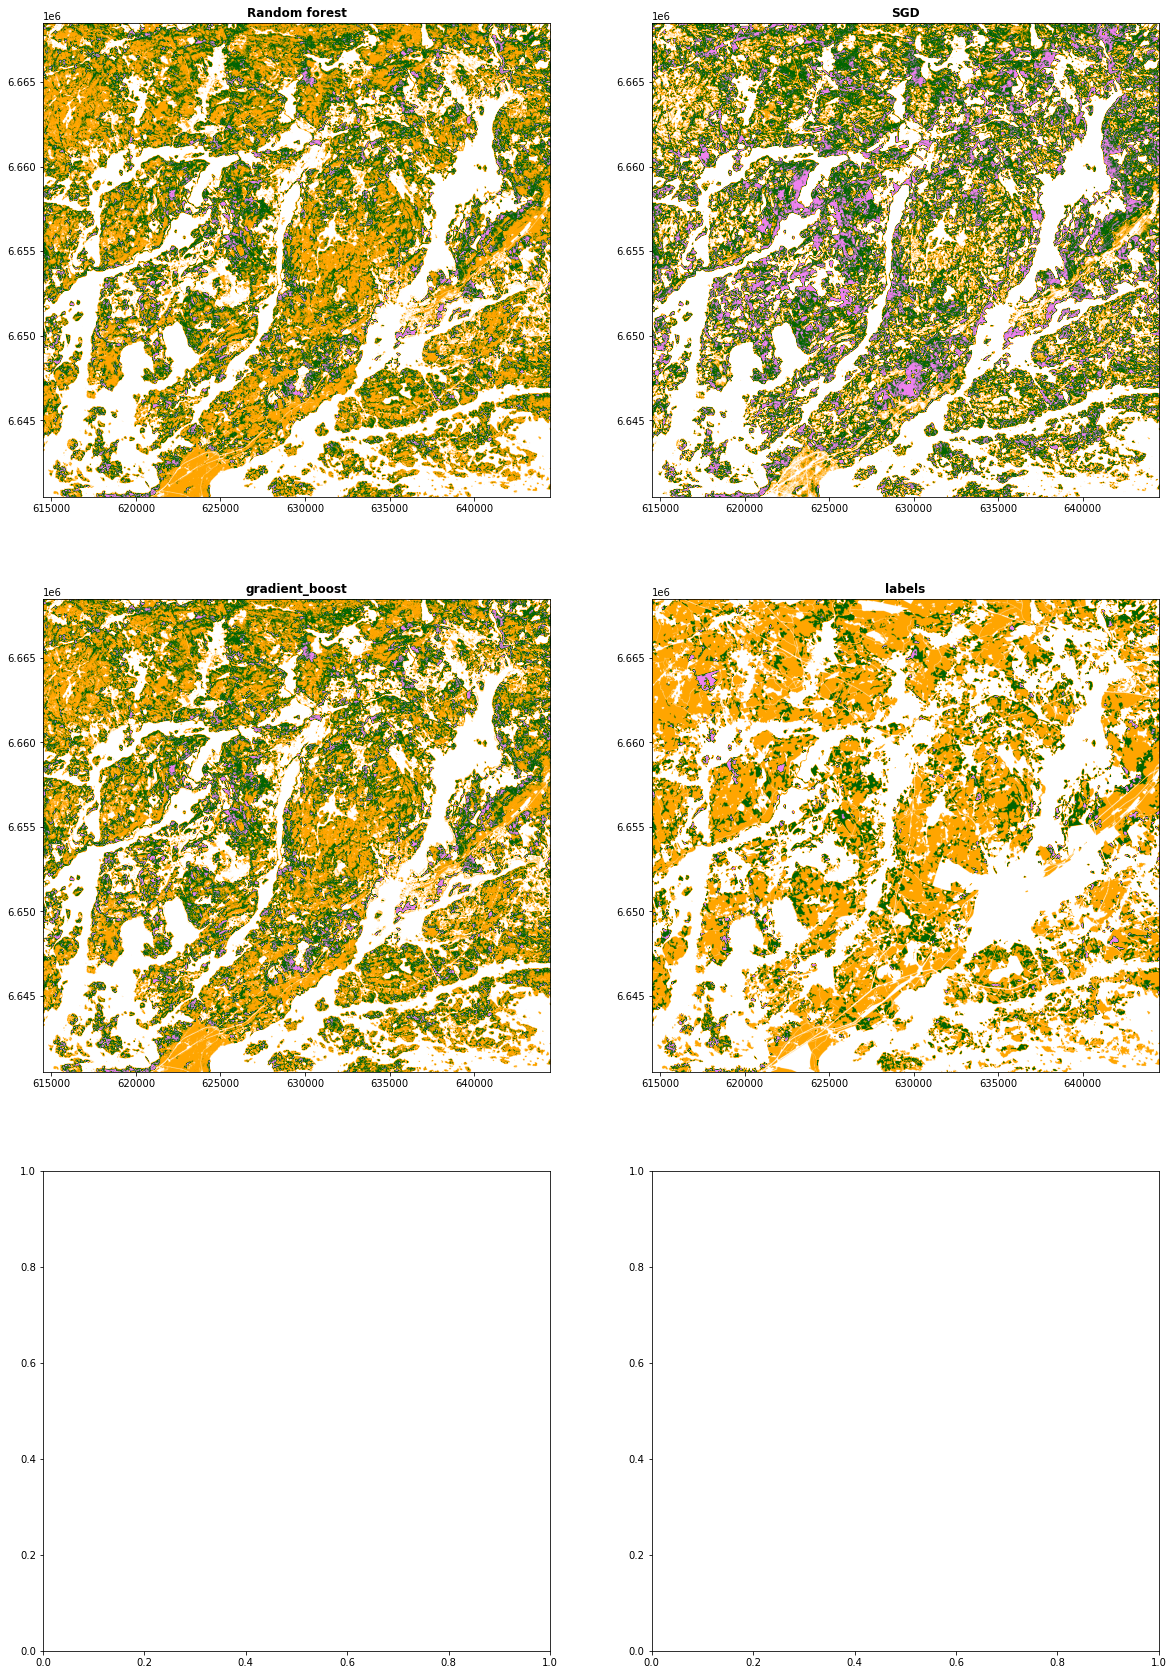

In [36]:
### Create a subplot for 4 images and plot the sentinel image 
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 30))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","darkgreen","violet"])

### The results
rf_results = rasterio.open(outputImageBase+'random_forest.tif')
show(rf_results, ax=ax[0, 0], cmap=cmap, title='Random forest')

SGD_results = rasterio.open(outputImageBase+'SGD.tif')
show(SGD_results, ax=ax[0, 1], cmap=cmap, title='SGD')

gradient_boost_results = rasterio.open(outputImageBase+'gradient_boost.tif')
show(gradient_boost_results, ax=ax[1, 0], cmap=cmap, title='gradient_boost')

#SVM_results = rasterio.open(outputImageBase+'SVM.tif')
#show(SVM_results, ax=ax[1, 1], cmap=cmap, title='SVM')

labels = rasterio.open(labelsImage)
show(labels, ax=ax[1,1], cmap=cmap, title='labels')

In [ ]:


### The forest classification
forest_classes = rasterio.open(forestClasses)
show(forest_classes, ax=ax[1, 0], cmap=cmap, title='Forest classes')

### Plot the histogram of clustering results
show_hist(classes2D, ax=ax[1, 1], bins=[-0.5,0.5,1.5,2.5,3.5,4.5], title="Clustering histogram") #,5.5,6.5